In this experiment, I followed an NLP tutorial on HuggingFace to finetune a pretrained BERT model on Named Entity Recognition task. The code was mostly from the [HuggingFace tutorial](https://huggingface.co/learn/nlp-course/chapter7/2?fw=pt). For learning purpose, I added some comments to explain the purpose of the code and some cells to check the content the nested data objects, which other learners may refer to if necessary.

The dataset used for finetuning was the `CoNLL-2003` dataset, which contains news stories from **Reuters**. As instructed in the HuggingFace tutorial, the main data processing step was to prepare the data so that the pretrained BERT model can learn classify each token. Because the original words might be separated into multiple tokens, the ground-truth labels (LOC, PER, ORG, etc.) also needs to be repeated into multiple tokens when their original words are tokenized into multiple tokens. Thus, for each tokenized input sequence, a label sequence of the same length and with the same padding mask is also prepared, so that the loss computation can be performed correctly.

The finetuned Named Entity Recognition model can be tested [here](https://huggingface.co/thuann2cats/bert-finetuned-ner-HF-tutorial-using-Trainer), thanks to HuggingFace's awesome Inference API.

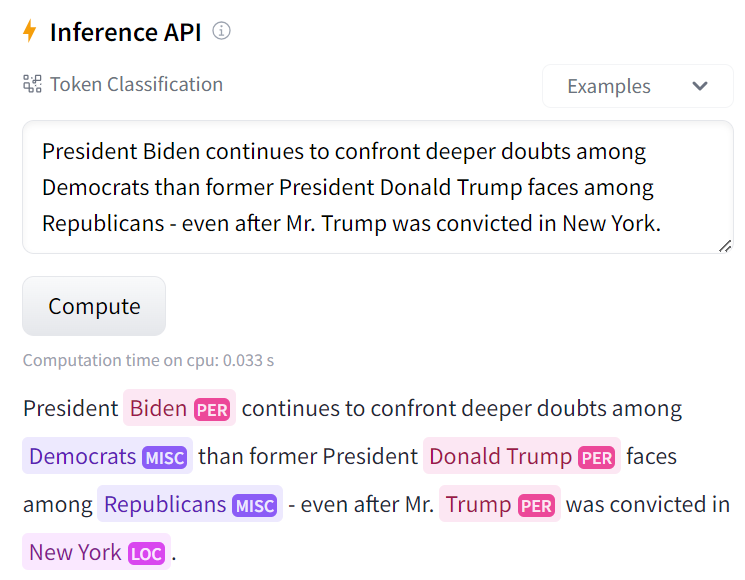




In [1]:
import torch
torch.cuda.is_available()

True

The CoNLL-2003 contains news stories from Reuters.

In [1]:
from datasets import load_dataset
raw_datasets = load_dataset("conll2003")

# Data Preprocessing

In [2]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

Here, `tokens` are not yet the tokenized IDs ready to be feed into the transformers model, but just words separated by spaces.

In [3]:
raw_datasets["train"][0]["tokens"]

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

In [4]:
raw_datasets["train"][0]["ner_tags"]

[3, 0, 7, 0, 0, 0, 7, 0, 0]

In [5]:
raw_datasets["train"][0]["pos_tags"]

[22, 42, 16, 21, 35, 37, 16, 21, 7]

In [6]:
raw_datasets["train"][0]["chunk_tags"]

[11, 21, 11, 12, 21, 22, 11, 12, 0]

There are nine NER tags.

In [7]:
ner_feature = raw_datasets["train"].features["ner_tags"]
ner_feature

Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)

In [8]:
label_names = ner_feature.feature.names
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [9]:
# this code aligns the words (`tokens`) in an example with the NER tag for illustration
words = raw_datasets["train"][0]["tokens"]
labels = raw_datasets["train"][0]["ner_tags"]
line1 = ""
line2 = ""
for word, label in zip(words, labels):
    full_label = label_names[label]
    max_length = max(len(word), len(full_label))
    line1 += word + " " * (max_length - len(word) + 1)
    line2 += full_label + " " * (max_length - len(full_label) + 1)
    
print(line1)
print(line2)    

EU    rejects German call to boycott British lamb . 
B-ORG O       B-MISC O    O  O       B-MISC  O    O 


In [10]:
# another example
words = raw_datasets["train"][4]["tokens"]
labels = raw_datasets["train"][4]["ner_tags"]
line1 = ""
line2 = ""
for word, label in zip(words, labels):
    full_label = label_names[label]
    max_length = max(len(word), len(full_label))
    line1 += word + " " * (max_length - len(word) + 1)
    line2 += full_label + " " * (max_length - len(full_label) + 1)
    
print(line1)
print(line2)    

Germany 's representative to the European Union 's veterinary committee Werner Zwingmann said on Wednesday consumers should buy sheepmeat from countries other than Britain until the scientific advice was clearer . 
B-LOC   O  O              O  O   B-ORG    I-ORG O  O          O         B-PER  I-PER     O    O  O         O         O      O   O         O    O         O     O    B-LOC   O     O   O          O      O   O       O 


In [11]:
from transformers import AutoTokenizer
model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [12]:
tokenizer.is_fast

True

In [13]:
raw_datasets["train"][0]["tokens"]

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

Because the default tokenizer may break up original words into multiple tokens, we write a function below to "expand" the `ner-tags` sequence, so that each tag that was originally associated with each word is duplicated to associate with multiple tokens, should that word be tokenized into multiple tags. We do that with the help of the `.word_ids()` mapping, which maps each token in the tokenized sequence with the index of the original word that the token was a part of.

In [14]:
inputs = tokenizer(raw_datasets["train"][0]["tokens"], is_split_into_words=True)
inputs

{'input_ids': [101, 7270, 22961, 1528, 1840, 1106, 21423, 1418, 2495, 12913, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [16]:
type(inputs)

transformers.tokenization_utils_base.BatchEncoding

In [15]:
inputs.tokens()

['[CLS]',
 'EU',
 'rejects',
 'German',
 'call',
 'to',
 'boycott',
 'British',
 'la',
 '##mb',
 '.',
 '[SEP]']

In [17]:
inputs.word_ids()

[None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]

In [18]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # start of a new word
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # special token
            new_labels.append(-100)
        else:
            # same word as previous token
            label = labels[word_id]
            # if the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)
    return new_labels



In this example, a `O` tag (which as NER tag id of 0) has been repeated because two tokens came from the word `7`.

In [19]:
labels = raw_datasets["train"][0]["ner_tags"]
word_ids = inputs.word_ids()
print(labels)
print(word_ids)
print(align_labels_with_tokens(labels, word_ids))

[3, 0, 7, 0, 0, 0, 7, 0, 0]
[None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]
[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]


In [20]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [21]:
# combine the steps into a function that can be passed into .map() of the dataset
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))
    
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs



In [22]:
tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

In [23]:
tokenized_datasets


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3453
    })
})

As introduced in the HuggingFace tutorial on token classification, we have to use the `DataCollatorForTokenClassification` because we need to pad not only the input tokens, but also our labels. As explained in the tutorial, our labels should be padded the exact same way as the inputs, using -100 as a value to signify the fact that the corresponding predictions must be ignored in the loss computation.

In [24]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

batch = data_collator([tokenized_datasets["train"][i] for i in range(2)])
batch["labels"]

tensor([[-100,    3,    0,    7,    0,    0,    0,    7,    0,    0,    0, -100],
        [-100,    1,    2, -100, -100, -100, -100, -100, -100, -100, -100, -100]])

The above version was padded. Compare that to the unpadded version below.

In [25]:
for i in range(2):
    print(tokenized_datasets["train"][i]["labels"])

[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]
[-100, 1, 2, -100]


In [26]:
# must install `seqeval` as instructed in the tutorial
import evaluate
metric = evaluate.load("seqeval")

In [27]:
labels = raw_datasets["train"][0]["ner_tags"]
labels = [label_names[i] for i in labels]
labels

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

In [28]:
predictions = labels.copy()
# Corrupting the ground-truth predictions in order to test the metric.compute() function
predictions[2] = "0"
metric.compute(predictions=[predictions], references=[labels])

/home/nguyenthuan49/anaconda3/envs/LLM-finetuning-Coursera/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


{'MISC': {'precision': np.float64(1.0),
  'recall': np.float64(0.5),
  'f1': np.float64(0.6666666666666666),
  'number': np.int64(2)},
 'ORG': {'precision': np.float64(1.0),
  'recall': np.float64(1.0),
  'f1': np.float64(1.0),
  'number': np.int64(1)},
 'overall_precision': np.float64(1.0),
 'overall_recall': np.float64(0.6666666666666666),
 'overall_f1': np.float64(0.8),
 'overall_accuracy': 0.8888888888888888}

Here, we write a `compute_metrics()` function so that we can pass the predictions after each epoch during training.

In [29]:

import numpy as np

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l!=-100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [30]:
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

In [31]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
model.config.num_labels

9

# Training using `Trainer`

In [33]:
from huggingface_hub import notebook_login
notebook_login()

In [34]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="bert-finetuned-ner-HF-tutorial-using-Trainer",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=True,
)

/home/nguyenthuan49/anaconda3/envs/LLM-finetuning-Coursera/lib/python3.12/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [35]:
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.076300,0.064168,0.907740,0.935544,0.921432,0.982737
2,0.034400,0.071482,0.928642,0.943958,0.936238,0.984665
3,0.023000,0.061834,0.936248,0.951531,0.943828,0.986696


TrainOutput(global_step=5268, training_loss=0.06644836771913613, metrics={'train_runtime': 709.3888, 'train_samples_per_second': 59.379, 'train_steps_per_second': 7.426, 'total_flos': 920771584279074.0, 'train_loss': 0.06644836771913613, 'epoch': 3.0})

In [41]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/thuann2cats/bert-finetuned-ner-HF-tutorial-using-Trainer/commit/b337da4c1641bc15a6ee411af6f7cb135a359727', commit_message='End of training', commit_description='', oid='b337da4c1641bc15a6ee411af6f7cb135a359727', pr_url=None, pr_revision=None, pr_num=None)

# Training using `Accelerator`

In [36]:
# full training loop
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], collate_fn=data_collator, batch_size=8
)

In [37]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:

from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=2e-5)

In [39]:
from accelerate import Accelerator
accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(model, optimizer, train_dataloader, eval_dataloader)

In [40]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)



In [42]:
from huggingface_hub import Repository, get_full_repo_name

model_name = "bert-finetuned-ner-HF-tutorial-using-Accelerator"

repo_name = get_full_repo_name(model_name)
repo_name

'thuann2cats/bert-finetuned-ner-HF-tutorial-using-Accelerator'

In [43]:
output_dir = "bert-finetuned-ner-accelerate-HF-tutorial"
repo = Repository(output_dir, clone_from=repo_name)

/home/nguyenthuan49/anaconda3/envs/LLM-finetuning-Coursera/lib/python3.12/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/thuann2cats/bert-finetuned-ner-HF-tutorial-using-Accelerator into local empty directory.


In [44]:
def postprocess(predictions, labels):
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()
    
    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l!=-100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l!=-100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_labels, true_predictions



In [45]:
from tqdm.auto import tqdm
import torch

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)
        
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        
    # Evaluation
    model.eval()
    for batch in eval_dataloader:
        with torch.no_grad():
            outputs = model(**batch)
            
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        
        # Necessary to pad predictions and labels for being gathered
        predictions = accelerator.pad_across_processes(predictions, dim=1, pad_index=-100)
        labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)
        
        predictions_gathered = accelerator.gather(predictions)
        labels_gathered = accelerator.gather(labels)
        
        true_predictions, true_labels = postprocess(predictions_gathered, labels_gathered)
        metric.add_batch(predictions=true_predictions, references=true_labels)
        
    results = metric.compute()
    print(
        f"epoch {epoch}:",
        {
            key: results[f"overall_{key}"]
            for key in ["precision", "recall", "f1", "accuracy"]
        },
    )
    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

  0%|          | 0/5268 [00:00<?, ?it/s]

epoch 0: {'precision': np.float64(0.9347021204981488), 'recall': np.float64(0.9038242473555737), 'f1': np.float64(0.9190038884752213), 'accuracy': 0.9812798022016836}
epoch 1: {'precision': np.float64(0.9404240996297543), 'recall': np.float64(0.918625678119349), 'f1': np.float64(0.9293970893970893), 'accuracy': 0.9833107670571614}
epoch 2: {'precision': np.float64(0.9488387748232918), 'recall': np.float64(0.9292895994725564), 'f1': np.float64(0.9389624448330418), 'accuracy': 0.9858568316948254}


# Using the model with `pipeline`

In [46]:
from transformers import pipeline

model_checkpoint = "thuann2cats/bert-finetuned-ner-HF-tutorial-using-Accelerator"

token_classifier = pipeline(
    "token-classification",
    model=model_checkpoint,
    aggregation_strategy="simple",
)

token_classifier("President Biden continues to confront deeper doubts among Democrats than former President Donald Trump faces among Republicans - even after Mr. Trump was convicted in New York.")

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

[{'entity_group': 'PER',
  'score': np.float32(0.9860419),
  'word': 'Biden',
  'start': 10,
  'end': 15},
 {'entity_group': 'MISC',
  'score': np.float32(0.99790144),
  'word': 'Democrats',
  'start': 58,
  'end': 67},
 {'entity_group': 'PER',
  'score': np.float32(0.9961759),
  'word': 'Donald Trump',
  'start': 90,
  'end': 102},
 {'entity_group': 'MISC',
  'score': np.float32(0.99738353),
  'word': 'Republicans',
  'start': 115,
  'end': 126},
 {'entity_group': 'PER',
  'score': np.float32(0.98340607),
  'word': 'Trump',
  'start': 144,
  'end': 149},
 {'entity_group': 'LOC',
  'score': np.float32(0.998245),
  'word': 'New York',
  'start': 167,
  'end': 175}]